# 2D CNN training
This notebook works as a proof of concept version for the actual script

## from scratch

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import glob
from functools import partial
from time import strftime

### data preparation

In [2]:
path_to_tfrs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray"
#path_to_tfrs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_rgb"
path_to_logs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/test_logs"
path_to_splits = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/split_text_files"

training_codename = "2D_fromscratch_0000"

num_classes = 2
sequence_to_train_on = "t1c"

time = strftime("run_%Y_%m_%d_%H_%M_%S")
class_directory = f"{training_codename}_{num_classes}_classes_{time}"

path_to_callbacks = Path(path_to_logs) / Path(class_directory)
os.makedirs(path_to_callbacks, exist_ok=True)

input_shape = (240, 240, 4)



## train / val / test split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

activation_func = "mish"
learning_rate = 0.001

early_stopping_patience = 150
shuffle_buffer_size = 20
repeat_count = 1

image_size = 224
batch_size = 16
EPOCHS = 30

len_train = 0
len_val = 0
len_test = 0

In [3]:
def get_patient_paths_for_fold(fold):
    # read .txt file
    txt_train_file_name = f"fold_{fold}_train_ids.txt"
    txt_val_file_name = f"fold_{fold}_val_ids.txt"

    with open(f"{path_to_splits}/{txt_train_file_name}", "r") as f:
        train_patients = [line.strip() for line in f]
        train_patients = [f"{path_to_tfrs}/{pat}" for pat in train_patients]

    with open(f"{path_to_splits}/{txt_val_file_name}", "r") as f:
        val_patients = [line.strip() for line in f]
        val_patients = [f"{path_to_tfrs}/{pat}" for pat in val_patients]

    return train_patients, val_patients

def get_patient_paths():
    patients = [f for f in os.listdir(path_to_tfrs) if os.path.isdir(os.path.join(path_to_tfrs, f))]

    patient_paths = [str(path_to_tfrs) + "/" + patient for patient in patients]

    print(f"total patients: {len(patient_paths)}")

    for path in patient_paths:
        patient_not_empty = False
        patient_files = os.listdir(path)
        for file in patient_files:
            if file.endswith(".tfrecord"):
                patient_not_empty = True
        
        if patient_not_empty == False:
            patient_paths.remove(path)

    return patient_paths

def split_patients(patient_paths, fraction_to_use = 1):

    random.shuffle(patient_paths)

    patient_paths = patient_paths[:int(len(patient_paths) * fraction_to_use)]

    if fraction_to_use != 1:
        print(f"actual tfrs length: {len(patient_paths)}")

    train_size = int(len(patient_paths) * train_ratio)
    val_size = int(len(patient_paths) * val_ratio)

    train_patients_paths = patient_paths[:train_size]
    val_patients_paths = patient_paths[train_size:train_size + val_size]
    test_patients_paths = patient_paths[train_size + val_size:]

    print(f"train: {len(train_patients_paths)} | val: {len(val_patients_paths)} | test: {len(test_patients_paths)}")

    # save train / val / test patients to txt file
    # hf.save_paths_to_txt(train_patients_paths, "train", path_to_callbacks)
    # hf.save_paths_to_txt(val_patients_paths, "val", path_to_callbacks)
    # hf.save_paths_to_txt(test_patients_paths, "test", path_to_callbacks)

    sum = len(train_patients_paths) + len(val_patients_paths) + len(test_patients_paths)
    if sum != len(patient_paths):
        print("WARNING: error occured in train / val / test split!")

    return train_patients_paths, val_patients_paths, test_patients_paths

def get_tfr_paths_for_patients(patient_paths):

    tfr_paths = []

    for patient in patient_paths:
        tfr_paths.extend(glob.glob(patient + "/*.tfrecord"))
    
    for path in tfr_paths:
        verify_tfrecord(path)

    #print(f"total tfrs: {len(tfr_paths)}")

    return tfr_paths

def read_data(train_paths, val_paths, test_paths = None, rgb = False):

    train_data = tf.data.Dataset.from_tensor_slices(train_paths)
    val_data = tf.data.Dataset.from_tensor_slices(val_paths)

    train_data = train_data.interleave(
        lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )
    val_data = val_data.interleave(
        lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )

    train_data = train_data.map(partial(parse_record, image_only = False, labeled = True, num_classes = num_classes, rgb = rgb), num_parallel_calls=tf.data.AUTOTUNE)
    val_data = val_data.map(partial(parse_record, image_only = False, labeled = True, num_classes = num_classes, rgb = rgb), num_parallel_calls=tf.data.AUTOTUNE)

    train_data = train_data.shuffle(buffer_size=shuffle_buffer_size)
    val_data = val_data.shuffle(buffer_size=shuffle_buffer_size)

    train_data = train_data.repeat(count = repeat_count)
    val_data = val_data.repeat(count = repeat_count)

    train_data = train_data.batch(batch_size)
    val_data = val_data.batch(batch_size)

    train_data = train_data.prefetch(buffer_size=1)
    val_data = val_data.prefetch(buffer_size=1)

    if test_paths is not None:
        test_data = tf.data.Dataset.from_tensor_slices(test_paths)
        test_data = test_data.interleave(
            lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False
        )
        test_data = test_data.map(partial(parse_record, image_only = False, labeled = True, num_classes = num_classes, rgb = rgb), num_parallel_calls=tf.data.AUTOTUNE)
        test_data = test_data.batch(batch_size)
        test_data = test_data.prefetch(buffer_size=1)

        return train_data, val_data, test_data

    return train_data, val_data

def parse_record(record, image_only = False, labeled = False, num_classes = 2, rgb = False, sequence = "t1c"):

    image_shape = []

    if rgb: # rgb images need three channels
        image_shape = [240, 240, 3, 4]
    else: # gray scale images don't
        image_shape = [240, 240, 4]

    feature_description = {
        "image": tf.io.FixedLenFeature(image_shape, tf.float32),
        "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
        "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
        "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }

    example = tf.io.parse_single_example(record, feature_description)
    image = example["image"]
    image = tf.reshape(image, image_shape)

    # primary should have a value between 0 and 5
    # depending on num classes return different values
    # if num_classes = 2, return 1 if primary is 1, else 0
    # if num_classes = 3, return primaries 1 and 2, else 0
    # if num_classes = 4, return primaries 1, 2 and 3, else 0
    # if num_classes = 5, return primaries 1, 2, 3 and 4, else 0
    # if num_classes = 6, return primaries 1, 2, 3, 4 and 5, else 0

    primary_to_return = tf.constant(0, dtype=tf.int64)

    if num_classes == 2:
        if example["primary"] == tf.constant(1, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 3:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 4:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 5:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64) or example["primary"] == tf.constant(4, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 6:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64) or example["primary"] == tf.constant(4, dtype=tf.int64) or example["primary"] == tf.constant(5, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    else:
            print("ERROR")
            print("num classes not supported")
            print("Check parse_record function")
            print("____________________________")

    if rgb: # select the right sequence to return
        if sequence == "t1":
            image = image[:, :, :, 0]
        elif sequence == "t1c":
            image = image[:, :, :, 1]
        elif sequence == "t2":
            image = image[:, :, :, 2]
        elif sequence == "flair":
            image = image[:, :, :, 3]

    if image_only:
        return image, primary_to_return
    elif labeled:
        return (image, example["sex"], example["age"]), primary_to_return #example["primary"]
    else:
        return image
    
def verify_tfrecord(file_path):
    try:
        for _ in tf.data.TFRecordDataset(file_path, compression_type="GZIP"):
            pass
    except tf.errors.DataLossError:
        print(f"Corrupted TFRecord file: {file_path}")

class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"\nEpoch {epoch+1}: val/train ratio: {ratio:.2f}")

class UnfreezeCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=3, monitor='val_accuracy', min_delta=0.01):
        super(UnfreezeCallback, self).__init__()
        self.patience = patience
        self.monitor = monitor
        self.min_delta = min_delta
        self.wait = 0
        self.best = -float('inf')
        self.unfreeze = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(f"Monitor {self.monitor} is not available in logs.")
        
        if current > self.best + self.min_delta:
            self.best = current
            self.wait = 0
            print("\nnot gonna unfreeze")
        else:
            self.wait += 1
            if self.wait >= self.patience and not self.unfreeze:
                print(f"\nUnfreezing layers at epoch {epoch + 1}")

                # for layer in self.model.get_layer('resnet50').layers:
                #     layer.trainable = True

                # self.model.save_weights('temp_weights.h5')

                self.model.stop_training = True
                # self.model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),  # Lower learning rate
                #                    loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # self.model.load_weights('temp_weights.h5')

                self.unfreeze = True
                self.wait = 0

unfreeze_callback = UnfreezeCallback(patience=1, monitor='val_accuracy', min_delta=0.01)

def get_callbacks(fold_num = 0,
                  use_checkpoint = True,
                  use_early_stopping = True,
                  early_stopping_patience = early_stopping_patience,
                  use_tensorboard = True,
                  use_csv_logger = True,
                  use_lrscheduler = False,
                  use_unfreeze = False):

    callbacks = []

    path_to_fold_callbacks = path_to_callbacks / f"fold_{fold_num}"

    def get_run_logdir(root_logdir = path_to_fold_callbacks / "tensorboard"):
        return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

    run_logdir = get_run_logdir()

    # model checkpoint
    if use_checkpoint:
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath = path_to_fold_callbacks / "saved_weights.weights.h5",
            monitor = "val_accuracy",
            mode = "max",
            save_best_only = True,
            save_weights_only = True,
        )
        callbacks.append(checkpoint_cb)

    # early stopping
    if use_early_stopping:
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            patience = early_stopping_patience,
            restore_best_weights = True,
            verbose = 1
        )
        callbacks.append(early_stopping_cb)

    # tensorboard, doesn't really work yet
    if use_tensorboard:
        tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = run_logdir,
                                                    histogram_freq = 1)
        callbacks.append(tensorboard_cb)
    
    # csv logger
    if use_csv_logger:
        csv_logger_cb = tf.keras.callbacks.CSVLogger(path_to_fold_callbacks / "training.csv", separator = ",", append = True)
        callbacks.append(csv_logger_cb)
    
    if use_lrscheduler:
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch * 0.0175))
        callbacks.append(lr_schedule)
    
    valtrainratio_callback = PrintValTrainRatioCallback()
    callbacks.append(valtrainratio_callback)

    if use_unfreeze:
        unfreeze_callback = UnfreezeCallback(patience=3, monitor='val_accuracy', min_delta=0.01)
        callbacks.append(unfreeze_callback)

    print("get_callbacks successful")

    return callbacks

### Data Augmentation

In [4]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized
    
    
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    #tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    #tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.1, 0.1), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest",
        interpolation = "bilinear"
    ),
    #tf.keras.layers.Resizing(image_size, image_size)
])

### Read Data

In [5]:
#patients = get_patient_paths()

train_patients, val_patients = get_patient_paths_for_fold(0)
print(train_patients)

#train_patients, val_patients, test_patients = split_patients(patients, fraction_to_use = 0.1)

train_paths = get_tfr_paths_for_patients(train_patients)
print(train_paths)
val_paths = get_tfr_paths_for_patients(val_patients)
print(val_paths)
#test_paths = get_tfr_paths_for_patients(test_patients)
#train_data, val_data, test_data = read_data(train_paths, val_paths, test_paths, rgb=True)
train_data, val_data = read_data(train_paths, val_paths, test_paths=None, rgb=False)


len_train = len(train_paths)
len_val = len(val_paths)
#len_test = len(test_paths)
#print(f"train: {len_train} | val: {len_val} | test: {len_test}")
print(f"train: {len_train} | val: {len_val}")

['/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-01673666', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-02115365', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-02074050', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-01661279', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-01650072', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-01205171', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-02184584', '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gra

In [6]:
callbacks = get_callbacks(0)

get_callbacks successful


#### preview single image

1
(16, 240, 240, 4)
(240, 240, 4)

Before Augmentation
Min: 0.0
Max: 255.0
Mean: 44.83970642089844
________________________________________

After Augmentation
Min: 0.0
Max: 1.0
Mean: 0.17584212124347687


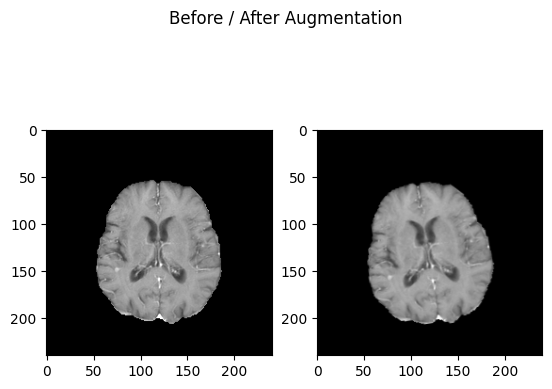

In [7]:
test_image = train_data.take(1)

for (image, sex, age), primary in test_image:
    print(primary.numpy()[0])
    print(image.shape)
    print(image[0].shape)
    image = image[0]
    imagebefore = image

    print()
    print("Before Augmentation")

    print(f"Min: {tf.reduce_min(image)}")
    print(f"Max: {tf.reduce_max(image)}")
    print(f"Mean: {tf.reduce_mean(image)}")

    print("________________________________________")
    print()
    print("After Augmentation")
    image = data_augmentation(image)
    print(f"Min: {tf.reduce_min(image)}")
    print(f"Max: {tf.reduce_max(image)}")
    print(f"Mean: {tf.reduce_mean(image)}")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Before / After Augmentation')
    ax1.imshow(imagebefore[:,:,1], cmap = "gray")
    ax2.imshow(image[:,:,1], cmap = "gray")    

In [27]:
class WeightedCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        cross_entropy = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)
        weights = tf.gather(self.class_weights, y_true)
        weighted_cross_entropy = weights * cross_entropy
        return tf.reduce_mean(weighted_cross_entropy)

In [17]:
class CrossWeightedEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights, from_logits=False, name="cross_weighted_entropy_loss"):
        super().__init__(name=name)
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        # Ensure y_true is of integer type and correct shape
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(y_true)  # Or use tf.squeeze(y_true)

        if self.from_logits:
            # Apply softmax to logits to get probabilities
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        else:
            # Ensure y_pred sums to 1 across classes
            y_pred = tf.math.divide_no_nan(y_pred, tf.reduce_sum(y_pred, axis=-1, keepdims=True))

        # Gather the predicted probabilities for the true classes
        indices = tf.stack([tf.range(tf.shape(y_true)[0]), y_true], axis=1)
        y_pred = tf.gather_nd(y_pred, indices)

        # Gather the weights for the true classes
        weights = tf.gather(self.class_weights, y_true)

        # Compute the weighted cross-entropy loss
        loss = -weights * tf.math.log(tf.clip_by_value(y_pred, 1e-15, 1.0))

        # Return the mean loss over the batch
        return tf.reduce_mean(loss)

In [26]:
two_class_weights = {1: 0.92156863, 0 :1.09302326}

### normal Conv model

In [23]:
def build_conv_model():

    DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation = activation_func, kernel_initializer="he_normal")

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 4))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))

    batch_norm_layer = tf.keras.layers.BatchNormalization()
    conv_1_layer = DefaultConv2D(filters = 64, kernel_size = 7, strides = 2, input_shape = [240, 240, 4])
    max_pool_1_layer = tf.keras.layers.MaxPool2D(pool_size = (2,2))

    conv_2_layer = DefaultConv2D(filters = 128)
    conv_3_layer = DefaultConv2D(filters = 128)
    max_pool_2_layer = tf.keras.layers.MaxPool2D(pool_size = (2,2))

    conv_4_layer = DefaultConv2D(filters = 256)
    conv_5_layer = DefaultConv2D(filters = 256)
    max_pool_3_layer = tf.keras.layers.MaxPool2D(pool_size = (2,2))
    
    # conv_4_layer = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides=(1,1,1), activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    # max_pool_4_layer = tf.keras.layers.MaxPool2D(pool_size = (2,2,2))

    dense_1_layer = tf.keras.layers.Dense(256, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)


    batch_norm = batch_norm_layer(image_input)

    conv_1 = conv_1_layer(batch_norm)
    max_pool_1 = max_pool_1_layer(conv_1)

    conv_2 = conv_2_layer(max_pool_1)
    conv_3 = conv_3_layer(conv_2)
    max_pool_2 = max_pool_2_layer(conv_3)

    conv_4 = conv_4_layer(max_pool_2)
    conv_5 = conv_5_layer(conv_4)
    max_pool_3 = max_pool_3_layer(conv_5)

    flatten = tf.keras.layers.Flatten()(max_pool_3)

    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)  # Reshape age_input to have 2 dimensions
    concatenated_inputs = tf.keras.layers.Concatenate()([flatten, age_input_reshaped, flattened_sex_input])

    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    match num_classes:
        case 2:
            x = tf.keras.layers.Dense(1)(x)
            output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        case 3:
            x = tf.keras.layers.Dense(3)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case 4:
            x = tf.keras.layers.Dense(4)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case 5:
            x = tf.keras.layers.Dense(5)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case 6:
            x = tf.keras.layers.Dense(6)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case _:
            print("Wrong num classes set in the buil_ai func, please pick a number between 2 and 6")

    model = tf.keras.Model(inputs = [image_input, sex_input, age_input], outputs = [output])

    if num_classes > 2:
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
    else:
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
        #model.compile(loss=CrossWeightedEntropyLoss(class_weights=two_class_weights), optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
    model.summary()

    return model

In [24]:
conv_model = build_conv_model()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 batch_normalization_4 (Bat  (None, 240, 240, 4)          16        ['input_13[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_20 (Conv2D)          (None, 120, 120, 64)         12608     ['batch_normalization_4[0][0]'
                                                                    ]                             
                                                                                            

### ResNet34

In [94]:
def build_resnet34_model():

    DefaultConv2D = partial(tf.keras.layers.Conv2D,
                            kernel_size=3,
                            strides = 1,
                            padding="same",
                            activation = activation_func,
                            kernel_initializer="he_normal",
                            use_bias=False)
    
    class ResidualUnit(tf.keras.layers.Layer):
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = tf.keras.activations.get(activation)
            self.main_layers = [
                DefaultConv2D(filters, strides = strides),
                tf.keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters),
                tf.keras.layers.BatchNormalization()
            ]
            self.skip_layers = []
            if strides > 1:
                self.skip_layers = [
                    DefaultConv2D(filters, kernel_size=1, strides=strides),
                    tf.keras.layers.BatchNormalization()
                ]
            
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)
    


    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 4))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))


    dense_1_layer = tf.keras.layers.Dense(256, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)

    augment = data_augmentation(image_input)

    x = DefaultConv2D(filters = 64, kernel_size = 7, strides = 2, input_shape = [240, 240, 4])(augment)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        x = ResidualUnit(filters, strides = strides)(x)
        prev_filters = filters
    
    x = tf.keras.layers.GlobalMaxPool2D()(x)
    resnet = tf.keras.layers.Flatten()(x)

    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)  # Reshape age_input to have 2 dimensions
    concatenated_inputs = tf.keras.layers.Concatenate()([resnet, age_input_reshaped, flattened_sex_input])

    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    match num_classes:
        case 2:
            x = tf.keras.layers.Dense(1)(x)
            output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        case 3 | 4 | 5 | 6:
            x = tf.keras.layers.Dense(num_classes)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case _:
            raise ValueError("num_classes must be 2, 3, 4, 5 or 6.")

    model = tf.keras.Model(inputs = [image_input, sex_input, age_input], outputs = [output], name = "resnet34_model")

    if num_classes > 2:
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
    else:
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
    model.summary()

    return model

In [95]:
resnet_34_model = build_resnet34_model()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 240, 240, 4)          0         ['input_40[0][0]']            
                                                                                                  
 conv2d_920 (Conv2D)         (None, 120, 120, 64)         12544     ['sequential_4[4][0]']        
                                                                                                  
 batch_normalization_904 (B  (None, 120, 120, 64)         256       ['conv2d_920[0][0]']          
 atchNormalization)                                                                    

### ResNet152

In [99]:
def build_resnet152_model():

    DefaultConv2D = partial(tf.keras.layers.Conv2D,
                            kernel_size=3,
                            strides = 1,
                            padding="same",
                            activation = activation_func,
                            kernel_initializer="he_normal",
                            use_bias=False)
    
    class BottleneckResidualUnit(tf.keras.layers.Layer):
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = tf.keras.activations.get(activation)
            self.strides = strides
            self.filters = filters

            self.main_layers = [
                tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", kernel_initializer="he_normal", use_bias=False),
                tf.keras.layers.BatchNormalization(),
                self.activation,
                tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False),
                tf.keras.layers.BatchNormalization(),
                self.activation,
                tf.keras.layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding="same", kernel_initializer="he_normal", use_bias=False),
                tf.keras.layers.BatchNormalization()
            ]

            self.skip_conv = tf.keras.layers.Conv2D(filters * 4, kernel_size=1, strides=strides, padding="same", kernel_initializer="he_normal", use_bias=False)
            #self.skip_layers = None
            self.skip_bn = tf.keras.layers.BatchNormalization()


        def buil(self, input_shape):
            if self.strides > 1 or input_shape[-1] != self.filters * 4:
                self.skip_layers = [
                    tf.keras.layers.Conv2D(self.filters * 4, kernel_size=1, strides=self.strides, padding="same", kernel_initializer="he_normal", use_bias=False),
                    tf.keras.layers.BatchNormalization()
                ]

        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            skip_Z = self.skip_conv(inputs)
            skip_Z = self.skip_bn(skip_Z)
            return self.activation(Z + skip_Z)
    

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    dense_1_layer = tf.keras.layers.Dense(256, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 4))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))

    augment = data_augmentation(image_input)


    x = DefaultConv2D(filters = 64, kernel_size = 7, strides = 2)(augment)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    block_config = [
        (64, 3, 1),
        (128, 8, 2),
        (256, 36, 2),
        (512, 3, 2)
    ]


    for filters, blocks, stride in block_config:
        for block in range(blocks):
            if block == 0:
                x = BottleneckResidualUnit(filters, strides=stride)(x)
            else:
                x = BottleneckResidualUnit(filters, strides=1)(x)

    x = tf.keras.layers.GlobalMaxPool2D()(x)
    resnet = tf.keras.layers.Flatten()(x)

    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)  # Reshape age_input to have 2 dimensions
    concatenated_inputs = tf.keras.layers.Concatenate()([resnet, age_input_reshaped, flattened_sex_input])

    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    match num_classes:
        case 2:
            x = tf.keras.layers.Dense(1)(x)
            output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        case 3 | 4 | 5 | 6:
            x = tf.keras.layers.Dense(num_classes)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case _:
            raise ValueError("num_classes must be 2, 3, 4, 5 or 6.")

    model = tf.keras.Model(inputs = [image_input, sex_input, age_input], outputs = [output], name = "resnet152_model")

    if num_classes > 2:
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
    else:
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ["RootMeanSquaredError", "accuracy"])
    model.summary()

    return model

In [100]:
resnet_152_model = build_resnet152_model()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 240, 240, 4)          0         ['input_49[0][0]']            
                                                                                                  
 conv2d_1002 (Conv2D)        (None, 120, 120, 64)         12544     ['sequential_4[6][0]']        
                                                                                                  
 batch_normalization_978 (B  (None, 120, 120, 64)         256       ['conv2d_1002[0][0]']         
 atchNormalization)                                                                    

### ResNeXt

In [113]:
def build_resnext_model(architecture="ResNeXt50"):

    architectures = {
        "ResNeXt50": [3, 4, 6, 3],
        "ResNeXt101": [3, 4, 23, 3],
    }

    if architecture not in architectures:
        raise ValueError(f"Architecture {architecture} not recognized. Available architectures: {list(architectures.keys())}")

    repetitions = architectures[architecture]

    DefaultConv2D = partial(tf.keras.layers.Conv2D,
                            kernel_size=3,
                            strides=1,
                            padding="same",
                            activation=None,
                            kernel_initializer="he_normal",
                            use_bias=False)
    
    class ResNeXtBlock(tf.keras.layers.Layer):
        def __init__(self, filters, cardinality, strides=1, input_filters = None, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = tf.keras.activations.get(activation)
            self.main_layers = [
                DefaultConv2D(filters // 2, kernel_size=1, strides=1),
                tf.keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters // 2, kernel_size=3, strides=strides, groups=cardinality),
                tf.keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters, kernel_size=1, strides=1),
                tf.keras.layers.BatchNormalization()
            ]
            self.skip_layers = []
            if strides > 1 or filters != input_filters:
                self.skip_layers = [
                    DefaultConv2D(filters, kernel_size=1, strides=strides),
                    tf.keras.layers.BatchNormalization()
                ]

        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 4))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))

    augment = data_augmentation(image_input)

    x = DefaultConv2D(filters=64, kernel_size=7, strides=2, input_shape=[240, 240, 4])(augment)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

    cardinality = 32
    filters = 128
    #repetitions = [3, 4, 6, 3]
    input_filters = x.shape[-1]
    for i, reps in enumerate(repetitions):
        for j in range(reps):
            strides = 1 if j != 0 else 2 #if i == 0 or
            x = ResNeXtBlock(filters, cardinality, strides=strides, input_filters=input_filters)(x)
            input_filters = filters
        filters *= 2

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    resnext = tf.keras.layers.Flatten()(x)

    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)
    concatenated_inputs = tf.keras.layers.Concatenate()([resnext, age_input_reshaped, flattened_sex_input])

    dense_1_layer = tf.keras.layers.Dense(256, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation=activation_func, kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)

    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    match num_classes:
        case 2:
            x = tf.keras.layers.Dense(1)(x)
            output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        case 3 | 4 | 5 | 6:
            x = tf.keras.layers.Dense(num_classes)(x)
            output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        case _:
            raise ValueError("num_classes must be 2, 3, 4, 5 or 6.")

    model = tf.keras.Model(inputs=[image_input, sex_input, age_input], outputs=[output], name=architecture)

    if num_classes > 2:
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["RootMeanSquaredError", "accuracy"])
    else:
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["RootMeanSquaredError", "accuracy"])
    model.summary()

    return model


In [115]:
resnext_50_model = build_resnext_model("ResNeXt50")

Model: "ResNeXt50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_73 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 240, 240, 4)          0         ['input_73[0][0]']            
                                                                                                  
 conv2d_1573 (Conv2D)        (None, 120, 120, 64)         12544     ['sequential_4[14][0]']       
                                                                                                  
 batch_normalization_1549 (  (None, 120, 120, 64)         256       ['conv2d_1573[0][0]']         
 BatchNormalization)                                                                      

### Train model

In [105]:
#model = resnext_50_model

In [27]:
history = conv_model.fit(x = train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            callbacks = callbacks,
            class_weight=two_class_weights
            )

Epoch 1/30
     43/Unknown - 18s 410ms/step - loss: 1.1367 - root_mean_squared_error: 0.5344 - accuracy: 0.6061

KeyboardInterrupt: 

## pretrained

### Vision Transformer

Import the standard libraries, watchout though: vit_keras uses tensorflow_addons, which has stopped any development

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import glob
from functools import partial
from time import strftime

#from vit_keras import vit

Matplotlib is building the font cache; this may take a moment.


helper functions below

In [20]:
path_to_tfrs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_rgb"
path_to_logs = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/test_logs"

training_codename = "2D_pretrained_0000"

num_classes = 4
sequence_to_train_on = "t1c"

time = strftime("run_%Y_%m_%d_%H_%M_%S")
class_directory = f"{training_codename}_{num_classes}_classes_{time}"

path_to_callbacks = Path(path_to_logs) / Path(class_directory)
os.makedirs(path_to_callbacks, exist_ok=True)


image_size = 224

## train / val / test split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

early_stopping_patience = 150
shuffle_buffer_size = 20
repeat_count = 1

image_size = 224
batch_size = 16
EPOCHS = 30

len_train = 0
len_val = 0
len_test = 0

In [21]:
def get_patient_paths():
    patients = [f for f in os.listdir(path_to_tfrs) if os.path.isdir(os.path.join(path_to_tfrs, f))]

    patient_paths = [str(path_to_tfrs) + "/" + patient for patient in patients]

    print(f"total patients: {len(patient_paths)}")

    for path in patient_paths:
        patient_not_empty = False
        patient_files = os.listdir(path)
        for file in patient_files:
            if file.endswith(".tfrecord"):
                patient_not_empty = True
        
        if patient_not_empty == False:
            patient_paths.remove(path)

    return patient_paths

def split_patients(patient_paths, fraction_to_use = 1):

    random.shuffle(patient_paths)

    patient_paths = patient_paths[:int(len(patient_paths) * fraction_to_use)]

    if fraction_to_use != 1:
        print(f"actual tfrs length: {len(patient_paths)}")

    train_size = int(len(patient_paths) * train_ratio)
    val_size = int(len(patient_paths) * val_ratio)

    train_patients_paths = patient_paths[:train_size]
    val_patients_paths = patient_paths[train_size:train_size + val_size]
    test_patients_paths = patient_paths[train_size + val_size:]

    print(f"train: {len(train_patients_paths)} | val: {len(val_patients_paths)} | test: {len(test_patients_paths)}")

    # save train / val / test patients to txt file
    # hf.save_paths_to_txt(train_patients_paths, "train", path_to_callbacks)
    # hf.save_paths_to_txt(val_patients_paths, "val", path_to_callbacks)
    # hf.save_paths_to_txt(test_patients_paths, "test", path_to_callbacks)

    sum = len(train_patients_paths) + len(val_patients_paths) + len(test_patients_paths)
    if sum != len(patient_paths):
        print("WARNING: error occured in train / val / test split!")

    return train_patients_paths, val_patients_paths, test_patients_paths

def get_tfr_paths_for_patients(patient_paths):

    tfr_paths = []

    for patient in patient_paths:
        tfr_paths.extend(glob.glob(patient + "/*.tfrecord"))
    
    for path in tfr_paths:
        verify_tfrecord(path)

    #print(f"total tfrs: {len(tfr_paths)}")

    return tfr_paths

def read_data(train_paths, val_paths, test_paths = None):

    train_data = tf.data.Dataset.from_tensor_slices(train_paths)
    val_data = tf.data.Dataset.from_tensor_slices(val_paths)

    train_data = train_data.interleave(
        lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )
    val_data = val_data.interleave(
        lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )

    train_data = train_data.map(partial(parse_record, image_only = False, labeled = True, num_classes = num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    val_data = val_data.map(partial(parse_record, image_only = False, labeled = True, num_classes = num_classes), num_parallel_calls=tf.data.AUTOTUNE)

    train_data = train_data.shuffle(buffer_size=shuffle_buffer_size)
    val_data = val_data.shuffle(buffer_size=shuffle_buffer_size)

    train_data = train_data.repeat(count = repeat_count)
    val_data = val_data.repeat(count = repeat_count)

    train_data = train_data.batch(batch_size)
    val_data = val_data.batch(batch_size)

    train_data = train_data.prefetch(buffer_size=1)
    val_data = val_data.prefetch(buffer_size=1)

    if test_paths is not None:
        test_data = tf.data.Dataset.from_tensor_slices(test_paths)
        test_data = test_data.interleave(
            lambda x: tf.data.TFRecordDataset([x], compression_type="GZIP"),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False
        )
        test_data = test_data.map(partial(parse_record, image_only = False, labeled = True, num_classes = num_classes), num_parallel_calls=tf.data.AUTOTUNE)
        test_data = test_data.batch(batch_size)
        test_data = test_data.prefetch(buffer_size=1)

        return train_data, val_data, test_data

    return train_data, val_data

def parse_record(record, image_only = False, labeled = False, num_classes = 2, sequence = "t1c"):

    feature_description = {
        "image": tf.io.FixedLenFeature([240, 240, 3, 4], tf.float32),
        "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
        "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
        "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }

    example = tf.io.parse_single_example(record, feature_description)
    image = example["image"]
    image = tf.reshape(image, [240, 240, 3, 4])
    #image = data_augmentation(image)

    # primary should have a value between 0 and 5
    # depending on num classes return different values
    # if num_classes = 2, return 1 if primary is 1, else 0
    # if num_classes = 3, return primaries 1 and 2, else 0
    # if num_classes = 4, return primaries 1, 2 and 3, else 0
    # if num_classes = 5, return primaries 1, 2, 3 and 4, else 0
    # if num_classes = 6, return primaries 1, 2, 3, 4 and 5, else 0

    primary_to_return = tf.constant(0, dtype=tf.int64)

    if num_classes == 2:
        if example["primary"] == tf.constant(1, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 3:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 4:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 5:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64) or example["primary"] == tf.constant(4, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    elif num_classes == 6:
        if example["primary"] == tf.constant(1, dtype=tf.int64) or example["primary"] == tf.constant(2, dtype=tf.int64) or example["primary"] == tf.constant(3, dtype=tf.int64) or example["primary"] == tf.constant(4, dtype=tf.int64) or example["primary"] == tf.constant(5, dtype=tf.int64):
            primary_to_return = example["primary"]
        else:
            primary_to_return = tf.constant(0, dtype=tf.int64)
    else:
            print("ERROR")
            print("num classes not supported")
            print("Check parse_record function")
            print("____________________________")

    
    if sequence == "t1":
        image = image[:, :, :, 0]
    elif sequence == "t1c":
        image = image[:, :, :, 1]
    elif sequence == "t2":
        image = image[:, :, :, 2]
    elif sequence == "flair":
        image = image[:, :, :, 3]

    if image_only:
        return image, primary_to_return
    elif labeled:
        return (image, example["sex"], example["age"]), primary_to_return #example["primary"]
    else:
        return image
    
def verify_tfrecord(file_path):
    try:
        for _ in tf.data.TFRecordDataset(file_path, compression_type="GZIP"):
            pass
    except tf.errors.DataLossError:
        print(f"Corrupted TFRecord file: {file_path}")

# class UnfreezeCallback(tf.keras.callbacks.Callback):
#     def __init__(self, patience=3, monitor='val_accuracy', min_delta=0.01):
#         super(UnfreezeCallback, self).__init__()
#         self.patience = patience
#         self.monitor = monitor
#         self.min_delta = min_delta
#         self.wait = 0
#         self.best = -float('inf')
#         self.unfreeze = False

#     def on_epoch_end(self, epoch, logs=None):
#         current = logs.get(self.monitor)
#         if current is None:
#             raise ValueError(f"Monitor {self.monitor} is not available in logs.")
        
#         if current > self.best + self.min_delta:
#             self.best = current
#             self.wait = 0
#             print("\nnot gonna unfreeze")
#         else:
#             self.wait += 1
#             if self.wait >= self.patience and not self.unfreeze:
#                 print(f"\nUnfreezing layers at epoch {epoch + 1}")

#                 # for layer in self.model.get_layer('resnet50').layers:
#                 #     layer.trainable = True

#                 # self.model.save_weights('temp_weights.h5')

#                 self.model.stop_training = True
#                 # self.model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),  # Lower learning rate
#                 #                    loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#                 # self.model.load_weights('temp_weights.h5')

#                 self.unfreeze = True
#                 self.wait = 0

def get_callbacks(fold_num = 0,
                  use_checkpoint = True,
                  use_early_stopping = True,
                  early_stopping_patience = early_stopping_patience,
                  use_tensorboard = True,
                  use_csv_logger = True,
                  use_lrscheduler = False):

    callbacks = []

    path_to_fold_callbacks = path_to_callbacks / f"fold_{fold_num}"

    def get_run_logdir(root_logdir = path_to_fold_callbacks / "tensorboard"):
        return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

    run_logdir = get_run_logdir()

    # model checkpoint
    if use_checkpoint:
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath = path_to_fold_callbacks / "saved_weights.weights.h5",
            monitor = "val_accuracy",
            mode = "max",
            save_best_only = True,
            save_weights_only = True,
        )
        callbacks.append(checkpoint_cb)

    # early stopping
    if use_early_stopping:
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            patience = early_stopping_patience,
            restore_best_weights = True,
            verbose = 1
        )
        callbacks.append(early_stopping_cb)

    # tensorboard, doesn't really work yet
    if use_tensorboard:
        tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = run_logdir,
                                                    histogram_freq = 1)
        callbacks.append(tensorboard_cb)
    
    # csv logger
    if use_csv_logger:
        csv_logger_cb = tf.keras.callbacks.CSVLogger(path_to_fold_callbacks / "training.csv", separator = ",", append = True)
        callbacks.append(csv_logger_cb)
    
    if use_lrscheduler:
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch * 0.0175))
        callbacks.append(lr_schedule)

    print("get_callbacks successful")

    return callbacks, path_to_fold_callbacks

Data augmentation

In [22]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized
    
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.1, 0.1), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest",
        interpolation = "bilinear"
    ),
    tf.keras.layers.Resizing(image_size, image_size)
])

In [23]:
patients = get_patient_paths()

train_patients, val_patients, test_patients = split_patients(patients, fraction_to_use = 0.1)

train_paths = get_tfr_paths_for_patients(train_patients)
val_paths = get_tfr_paths_for_patients(val_patients)
test_paths = get_tfr_paths_for_patients(test_patients)
train_data, val_data, test_data = read_data(train_paths, val_paths, test_paths)

len_train = len(train_paths)
len_val = len(val_paths)
len_test = len(test_paths)
print(f"train: {len_train} | val: {len_val} | test: {len_test}")

#callbacks, path_to_callbacks = get_callbacks(0)

total patients: 471
actual tfrs length: 46
train: 36 | val: 4 | test: 6
train: 136 | val: 7 | test: 23


In [9]:
test_image = train_data.take(1)

for image, primary in test_image:
    print(primary.numpy()[0])
    print(image.shape)
    print(image[0].shape)
    image = image[0]
    print(f"Min: {tf.reduce_min(image)}")
    print(f"Max: {tf.reduce_max(image)}")
    print(f"Mean: {tf.reduce_mean(image)}")

    image = data_augmentation(image)
    print()
    print(f"Min: {tf.reduce_min(image)}")
    print(f"Max: {tf.reduce_max(image)}")
    print(f"Mean: {tf.reduce_mean(image)}")
    print(image.shape)

    print()
    print(primary.numpy().shape)

    plt.imshow(image, cmap = "gray")
    

2


AttributeError: 'tuple' object has no attribute 'shape'

In [10]:
# Load the pretrained ResNet50 model without the top classification layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

class UnfreezeCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=3, monitor='val_accuracy', min_delta=0.01):
        super(UnfreezeCallback, self).__init__()
        self.patience = patience
        self.monitor = monitor
        self.min_delta = min_delta
        self.wait = 0
        self.best = -float('inf')
        self.unfreeze = False

    def on_epoch_end(self, epoch, logs=None):
        print("Epoch ended")

        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(f"Monitor {self.monitor} is not available in logs.")
        
        if current > self.best + self.min_delta:
            self.best = current
            self.wait = 0
            print("\nnot gonna unfreeze")
        else:
            self.wait += 1
            if self.wait >= self.patience and not self.unfreeze:
                print(f"\nUnfreezing layers at epoch {epoch + 1}")

                # for layer in self.model.get_layer('resnet50').layers:
                #     layer.trainable = True

                # self.model.save_weights('temp_weights.h5')

                self.model.stop_training = True
                # self.model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),  # Lower learning rate
                #                    loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # self.model.load_weights('temp_weights.h5')

                self.unfreeze = True
                self.wait = 0

# Define a custom callback to unfreeze layers
# class UnfreezeCallback(tf.keras.callbacks.Callback):
#     def __init__(self, patience=3, monitor='val_accuracy', min_delta=0.01):
#         super(UnfreezeCallback, self).__init__()
#         self.patience = patience
#         self.monitor = monitor
#         self.min_delta = min_delta
#         self.wait = 0
#         self.best = -float('inf')
#         self.unfreeze = False

#     def on_epoch_end(self, epoch, logs=None):
#         current = logs.get(self.monitor)
#         if current is None:
#             raise ValueError(f"Monitor {self.monitor} is not available in logs.")
        
#         if current > self.best + self.min_delta:
#             self.best = current
#             self.wait = 0
#             print(f"Best {self.monitor} value improved to {self.best}")
#         else:
#             self.wait += 1
#             if self.wait >= self.patience and not self.unfreeze:
#                 print(f"\nUnfreezing layers at epoch {epoch + 1}")
#                 #self.model.layers[1].trainable = True  # Unfreeze the base model
#                 for layer in self.model.get_layer("resnnet50").layers:
#                     layer.trainable = True
#                 self.model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),  # Lower learning rate
#                                    loss=self.model.loss, metrics=self.model.metrics)
#                 self.unfreeze = True

#unfreeze_callback = UnfreezeCallback(patience=3, monitor='val_accuracy', min_delta=0.01)

In [7]:
def build_model():

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 3))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))

    augmented = data_augmentation(image_input)

    # Preprocess the image input for ResNet50
    #preprocess_input = tf.keras.applications.resnet50.preprocess_input(augmented)

    # Use the pretrained base model
    x = base_model(augmented)
    x = tf.keras.layers.GlobalMaxPool2D()(x)
    resnet_output = tf.keras.layers.Flatten()(x)

    # Process sex and age inputs
    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)
    concatenated_inputs = tf.keras.layers.Concatenate()([resnet_output, age_input_reshaped, flattened_sex_input])

    # Define dense and dropout layers
    dense_1_layer = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)

    # Fully connected layers
    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    # Output layer
    if num_classes == 2:
        x = tf.keras.layers.Dense(1)(x)
        output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        loss = 'binary_crossentropy'
    else:
        x = tf.keras.layers.Dense(num_classes)(x)
        output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        loss = 'sparse_categorical_crossentropy'

    model = tf.keras.Model(inputs=[image_input, sex_input, age_input], outputs=[output], name='pretrained_resnet50_model')

    model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), metrics=['accuracy'])

    model.summary()

    return model

In [11]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath = path_to_logs + "/delete_me_not_important" + "/saved_weights.weights.h5",
        monitor = "val_accuracy",
        mode = "max",
        save_best_only = True,
        save_weights_only = True,
    )

unfreeze_callback = UnfreezeCallback(patience=1, monitor='val_accuracy', min_delta=0.01)


In [12]:

callbacks, path = get_callbacks(0, use_checkpoint=False)

callbacks_first = callbacks + [unfreeze_callback, checkpoint_cb]

print(callbacks_first)

get_callbacks successful
[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x360b59690>, <keras.src.callbacks.tensorboard.TensorBoard object at 0x3607ae5d0>, <keras.src.callbacks.csv_logger.CSVLogger object at 0x3607f0a50>, <__main__.UnfreezeCallback object at 0x35eb2f710>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x360a48910>]


In [10]:
conv_model = build_model()


#unfreeze_callback = UnfreezeCallback(patience=1, monitor='val_accuracy', min_delta=0.01)

#callbacks_with_unfreeze = callbacks.append(unfreeze_callback)

history = conv_model.fit(train_data,
                         validation_data = val_data,
                         epochs = EPOCHS,
                         batch_size = batch_size,
                         callbacks = callbacks_first)

path_to_weights = path_to_logs + "/delete_me_not_important" + "/saved_weights.weights.h5"

print("WHATS GOING ON!!!!!!!!!!!!!!!!!")

conv_model.load_weights(path_to_weights)
print("loaded weights")

conv_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), metrics=['accuracy'])
print("recompiled model")

history = conv_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Continue for more epochs
    initial_epoch=history.epoch[-1],  # Start from where it left off
    callbacks=callbacks  # Optionally use checkpoint again
)


Model: "pretrained_resnet50_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['sequential[0][0]']          
                                                          2                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 2048)                 0         ['resn

KeyboardInterrupt: 

In [350]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        #classes = 3
        )

#vit_model.build(input_shape=(image_size, image_size, 3))

/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/brain_mets_env/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [351]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [352]:
#input_shape = (224, 224, 3)
#inputs = tf.keras.Input(shape = input_shape)

model_vit = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = (240, 240, 3)),
        data_augmentation,
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(3, activation = 'softmax')
    ],
    name = 'vision_transformer')

model_vit.build()

model_vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (224, 224, 3)             0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_13 (Flatten)        (None, 768)               0         
                                                                 
 batch_normalization_26 (Ba  (None, 768)               3072      
 tchNormalization)                                               
                                                                 
 dense_52 (Dense)            (None, 128)               98432     
                                                                 
 batch_normalization_27 (Ba  (None, 128)               512       
 tchNormalization)                              

In [353]:
learning_rate = 1e-4

optimizer = tf.optimizers.legacy.Adam(learning_rate = learning_rate)

model_vit.compile(optimizer = optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model_vit.fit(x = train_data,
          validation_data = val_data,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30


49/49 [==============================] - 186s 4s/step - loss: 1.1954 - accuracy: 0.3222 - val_loss: 1.5543 - val_accuracy: 0.2365
Epoch 2/30
49/49 [==============================] - 176s 4s/step - loss: 1.0872 - accuracy: 0.4433 - val_loss: 2.0845 - val_accuracy: 0.2500
Epoch 3/30
49/49 [==============================] - 180s 4s/step - loss: 1.0691 - accuracy: 0.4845 - val_loss: 1.8574 - val_accuracy: 0.1757
Epoch 4/30
49/49 [==============================] - 180s 4s/step - loss: 1.0676 - accuracy: 0.4601 - val_loss: 1.7427 - val_accuracy: 0.2838
Epoch 5/30
34/49 [===================>..........] - ETA: 51s - loss: 1.0236 - accuracy: 0.5129

KeyboardInterrupt: 

### ResNet50V2

In [28]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg',
    weights='imagenet',
)

inception = tf.keras.applications.InceptionV3(
    include_top=False,
)

In [29]:
model_resnet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (240, 240, 3)),
    data_augmentation,
    inception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu),
    tf.keras.layers.Dense(3, activation = 'softmax')
], name = "resnet")

model_resnet.build()

model_resnet.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_96 (Ba  (None, 51200)             204800    
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 128)               6553728   
                                                                 
 batch_normalization_97 (Ba  (None, 128)               512  

In [27]:
model_resnet.get_layer('resnet50v2').trainable = False

In [361]:
learning_rate = 1e-4

optimizer = tf.optimizers.legacy.Adam(learning_rate = learning_rate)

model_resnet.compile(optimizer = optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model_resnet.fit(x = train_data,
          validation_data = val_data,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
58/58 [==============================] - 61s 997ms/step - loss: 1.4287 - accuracy: 0.3326 - val_loss: 1.1051 - val_accuracy: 0.3125
Epoch 2/30
58/58 [==============================] - 56s 965ms/step - loss: 1.3176 - accuracy: 0.3769 - val_loss: 1.0731 - val_accuracy: 0.4250
Epoch 3/30
58/58 [==============================] - 58s 994ms/step - loss: 1.2791 - accuracy: 0.3855 - val_loss: 1.0531 - val_accuracy: 0.6125
Epoch 4/30
58/58 [==============================] - 57s 980ms/step - loss: 1.3141 - accuracy: 0.3585 - val_loss: 0.9283 - val_accuracy: 0.6250
Epoch 5/30
58/58 [==============================] - 57s 974ms/step - loss: 1.2650 - accuracy: 0.3629 - val_loss: 1.0888 - val_accuracy: 0.3375
Epoch 6/30
58/58 [==============================] - 56s 970ms/step - loss: 1.2817 - accuracy: 0.3488 - val_loss: 1.0709 - val_accuracy: 0.4125
Epoch 7/30
 8/58 [===>..........................] - ETA: 49s - loss: 1.1981 - accuracy: 0.3516

KeyboardInterrupt: 

Pretrained models\
https://www.kaggle.com/models/tensorflow/inception \
https://www.kaggle.com/models/google/bit \
https://www.kaggle.com/models/google/efficientnet-v2 \
https://www.kaggle.com/models/spsayakpaul/vision-transformer \
https://www.kaggle.com/models/spsayakpaul/convnext


### Inception-v3

https://www.kaggle.com/models/google/inception-v3

In [ ]:
# needs an image_size of 299, 299, 3; color values between 0 and 1

hub.KerasLayer("https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2",
                   trainable=False)

In [8]:
image_size = 299

class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized
    
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.1, 0.1), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest",
        interpolation = "bilinear"
    ),
    tf.keras.layers.Resizing(image_size, image_size)
])

In [35]:
def build_inception_3_model():

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 3))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))

    augmented = data_augmentation(image_input)
    
    tf.print("Augmented shape:", augmented.shape)

    # Use the pretrained base model
    x = tf.keras.applications.InceptionV3(include_top = False)(augmented)
    #x = hub.KerasLayer("https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2", trainable=False)(augmented)
    tf.print("After InceptionV3 layer shape:", x.shape)
    
    x = tf.keras.layers.GlobalMaxPool2D()(x)
    tf.print("After GlobalMaxPool2D shape:", x.shape)

    output = tf.keras.layers.Flatten()(x)

    # Process sex and age inputs
    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)
    concatenated_inputs = tf.keras.layers.Concatenate()([output, age_input_reshaped, flattened_sex_input])

    # Define dense and dropout layers
    dense_1_layer = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)

    # Fully connected layers
    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    # Output layer
    if num_classes == 2:
        x = tf.keras.layers.Dense(1)(x)
        output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        loss = 'binary_crossentropy'
    else:
        x = tf.keras.layers.Dense(num_classes)(x)
        output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        loss = 'sparse_categorical_crossentropy'

    model = tf.keras.Model(inputs=[image_input, sex_input, age_input], outputs=[output], name='pretrained_resnet50_model')

    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

    model.summary()

    return model

In [36]:
inception_model = build_inception_3_model()

history = inception_model.fit(train_data,
                         validation_data = val_data,
                         epochs = EPOCHS,
                         batch_size = batch_size,
                         callbacks = callbacks)

Augmented shape: (None, 299, 299, 3)
After InceptionV3 layer shape: (None, 8, 8, 2048)
After GlobalMaxPool2D shape: (None, 2048)


Model: "pretrained_resnet50_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 299, 299,  │          0 │ input_layer_36[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 8, 8,      │ 21,802,784 │ sequential_1[5][… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_38      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_37      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 2048)      │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1)         │          0 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 1)         │          0 │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 2050)      │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0],  │
│                     │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    525,056 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 4)         │        516 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions         │ (None, 4)         │          0 │ dense_13[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,361,252 (85.30 MB)

 Trainable params: 22,326,820 (85.17 MB)

 Non-trainable params: 34,432 (134.50 KB)

Epoch 1/30
     10/Unknown 33s 1s/step - accuracy: 0.3342 - loss: 8.3485

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


KeyboardInterrupt: 

### Big Transfer (BiT)

In [6]:
import tensorflow_hub as hub

In [4]:
print(tf.__version__)

2.14.0


In [7]:
bit_sequential = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/bit/TensorFlow2/m-r152x4/1")
])

In [41]:

class MyBiTModel(tf.keras.Model):

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.augmentation = data_augmentation
    self.bit_model = module
    self.maxpool = tf.keras.layers.GlobalMaxPool2D()
    self.bit_flatten = tf.keras.layers.Flatten()

    self.sex_flatten = tf.keras.layers.Flatten()
    self.age_flatten = tf.keras.layers.Flatten()
    self.concat = tf.keras.layers.Concatenate()

    self.head = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation = 'relu', kernel_initializer = tf.keras.initializers.HeNormal()),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer = tf.keras.initializers.HeNormal()),
      tf.keras.layers.Dropout(0.5),
    ])

    if num_classes == 2:
      self.head.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
      self.loss = 'binary_crossentropy'
    elif num_classes > 2 and num_classes <= 6:
      self.head.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))
      self.loss = 'sparse_categorical_crossentropy'
  
  def call(self, inputs):

    image_input = inputs[0]
    sex_input = inputs[1]
    age_input = inputs[2]

    x = data_augmentation(image_input)
    x = self.bit_model(x)
    x = self.maxpool(x)
    x = self.bit_flatten(x)

    flattened_sex_input = self.sex_flatten(sex_input)
    flattened_age_input = self.age_flatten(age_input)
    x = self.concat([x, flattened_sex_input, flattened_age_input])

    return self.head(x)
  
model = MyBiTModel(num_classes=4, module=module)

# example_sequential = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape = (240, 240, 3)),
#     module,
#     tf.keras.layers.Dense(100, activation = 'relu'),
#     tf.keras.layers.Dense(3, activation = 'softmax')
# ])

image_size = 480 # because the images are larger than 96 px



In [43]:
input_shape = (image_size, image_size, 3)
sex_shape = (1,)
age_shape = (1,)

model.build([input_shape, sex_shape, age_shape])

/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/brain_mets_env/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'my_bi_t_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [47]:
model.compile(loss = model.loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), metrics = ['accuracy'])

In [48]:
model.summary()

Model: "my_bi_t_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_4          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_12 (Concatenate)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.fit(train_data, epochs = 5)

Epoch 1/5


ValueError: Exception encountered when calling MyBiTModel.call().

[1mInput 0 of layer "global_max_pooling2d_4" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 8192)[0m

Arguments received by MyBiTModel.call():
  • inputs=('tf.Tensor(shape=(None, 240, 240, 3), dtype=float32)', 'tf.Tensor(shape=(None,), dtype=int64)', 'tf.Tensor(shape=(None,), dtype=int64)')

In [14]:
num_classes = 4

In [12]:
def build_bit_model():

    # Define inputs
    image_input = tf.keras.layers.Input(shape=(240, 240, 3))
    sex_input = tf.keras.layers.Input(shape=(1,))
    age_input = tf.keras.layers.Input(shape=(1,))

    augmented = data_augmentation(image_input)
    
    tf.print("Augmented shape:", augmented.shape)

    # Use the pretrained base model
    #x = tf.keras.applications.InceptionV3(include_top = False)(augmented)
    x = hub.KerasLayer("https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2", trainable=False)(augmented)
    tf.print("After Bit layer shape:", x.shape)
    
    #x = tf.keras.layers.GlobalMaxPool2D()(x)
    #tf.print("After GlobalMaxPool2D shape:", x.shape)

    output = tf.keras.layers.Flatten()(x)

    # Process sex and age inputs
    flattened_sex_input = tf.keras.layers.Flatten()(sex_input)
    age_input_reshaped = tf.keras.layers.Reshape((1,))(age_input)
    concatenated_inputs = tf.keras.layers.Concatenate()([output, age_input_reshaped, flattened_sex_input])

    # Define dense and dropout layers
    dense_1_layer = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_1_layer = tf.keras.layers.Dropout(0.5)
    dense_2_layer = tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())
    dropout_2_layer = tf.keras.layers.Dropout(0.5)

    # Fully connected layers
    x = dense_1_layer(concatenated_inputs)
    x = dropout_1_layer(x)
    x = dense_2_layer(x)
    x = dropout_2_layer(x)

    # Output layer
    if num_classes == 2:
        x = tf.keras.layers.Dense(1)(x)
        output = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')(x)
        loss = 'binary_crossentropy'
    else:
        x = tf.keras.layers.Dense(num_classes)(x)
        output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
        loss = 'sparse_categorical_crossentropy'

    model = tf.keras.Model(inputs=[image_input, sex_input, age_input], outputs=[output], name='pretrained_resnet50_model')

    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

    model.summary()

    return model

In [15]:
bit_model = build_bit_model()

Augmented shape: TensorShape([None, 299, 299, 3])
After Bit layer shape: TensorShape([None, 2048])


Model: "pretrained_resnet50_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 299, 299, 3)          0         ['input_7[0][0]']             
                                                                                                  
 keras_layer_3 (KerasLayer)  (None, 2048)                 2180278   ['sequential_1[2][0]']        
                                                          4                                       
                                                                                                  
 input_9 (InputLayer)        [(None, 1)]                  0         []    

In [10]:
model.compile(loss = model.loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), metrics = ['accuracy'])

NameError: name 'model' is not defined